# Climate Variables Generation

In this notebook, we generate exogenous variables related to climate to complement our existing groundwater dataset. In future stages of the project, these climate-related features will be integrated into the dataset to enhance our predictive models and provide a more comprehensive understanding of the environmental factors influencing groundwater levels. The data was downloaded from the **Data Hub der GeoSphere Austria**.

#### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import missingno as msno
geopy

In [2]:
# Instruction to show all rows and columns when printing dataframes 
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", None)

#### Loading auxiliary data

In [ ]:
training_data_df = pd.read_csv('full_training_data_df_stage4_with_taikai.csv')
training_data_df['id_loc'] = training_data_df['id_loc'].astype(str)

### Loading and transforming data

In [3]:
# Load climate data and metadata for meteorological stations
stations_metadata = pd.read_csv("Datos/Clima/stations_metadaten.csv").iloc[:, [0, 3, 4]]
stations_metadata.columns = ["id", "Longitude", "Latitude"]

# Function to extract the region name from the filename
def extract_region_from_filename(filename):
    return '_'.join(filename.split('_')[2:]).replace('.csv', '')

# Load and concatenate all CSV files from the "auxiliary_data/climate/db1"
climate_data = pd.concat(
    [pd.read_csv(os.path.join("Datos/Clima/db1", f)).assign(region=extract_region_from_filename(f)) 
     for f in os.listdir("Datos/Clima/db1") if f.endswith('.csv')],
    ignore_index=True
)

# Function to transform values by splitting at the underscore and keeping only the part before the underscore
def transform_value(value):
    # Check if the value contains an underscore
    if '_' in value:
        # If it does, return the part before the underscore
        return value.split('_')[0]
    else:
        # If no underscore is present, return the value unchanged
        return value

# Apply the transform_value function to the 'region' column to standardize region names
climate_data['region'] = climate_data['region'].apply(transform_value)

In [4]:
# We load the coordinates for every gw location (generated in Data_Processing.ipynb)
with open('loc_coords.json', 'r') as json_file:
    loc_coord_dict = json.load(json_file)

### Finding the 5 nearest metheorological stations to every groundwater location

In [5]:
from geopy.distance import geodesic

def find_nearest_stations(coord, stations_metadata, n=5):
    """
    Find the 'n' nearest meteorological stations based on geographic coordinates.

    This function calculates the geodesic distance between a given location and all the meteorological 
    stations in the metadata, and returns the IDs of the 'n' closest stations.

    Parameters:
    coord (str): A string representing the geographic coordinates (latitude, longitude) in the format 'lat, lon'.
    stations_metadata (pd.DataFrame): A DataFrame containing station metadata with columns 'Latitude', 'Longitude', and 'id'.
    n (int): The number of nearest stations to return (default is 5).

    Returns:
    list: A list of station IDs representing the 'n' nearest stations, sorted by proximity.
    """
    # Convert the coordinate string into a tuple of floats (latitude, longitude)
    coord_tuple = tuple(map(float, coord.split(', ')))
    
    distances = []
    
    # Iterate through each station in the metadata to calculate the distance from the given coordinate
    for _, station in stations_metadata.iterrows():
        station_coord = (station['Latitude'], station['Longitude'])
        distance = geodesic(coord_tuple, station_coord).kilometers
        distances.append((station['id'], distance))
    
    # Sort the stations by distance (ascending)
    distances.sort(key=lambda x: x[1])
    
    # Select the IDs of the n nearest stations
    nearest_stations = [str(int(station_id)) for station_id, _ in distances[:n]]
    
    return nearest_stations

# Assign the 5 nearest stations to each location in loc_coord_dict
nearest_stations_dict = {code: find_nearest_stations(coord, stations_metadata) for code, coord in loc_coord_dict.items()}

# Show dictionary of nearest stations
nearest_stations_dict

{'324095': ['3252', '3257', '3267', '3200', '56'],
 '323295': ['3252', '3257', '3267', '3200', '56'],
 '323154': ['3267', '3257', '3252', '56', '3202'],
 '304535': ['4305', '4223', '134', '4224', '4220'],
 '326934': ['7653', '7715', '7603', '112', '7604'],
 '307397': ['5000', '4910', '3120', '4905', '3251'],
 '319053': ['20900', '11', '20903', '20901', '20902'],
 '303727': ['4060', '51', '4081', '4080', '4050'],
 '319699': ['5935', '5905', '105', '5901', '5904'],
 '304352': ['51', '4081', '4080', '4060', '3930'],
 '328419': ['11108', '11146', '15', '11102', '11104'],
 '328724': ['16100', '115', '16101', '13115', '124'],
 '318824': ['30', '16414', '16402', '16412', '16413'],
 '329789': ['19010', '54', '19021', '16400', '16401'],
 '313700': ['5990', '5916', '31', '5972', '107'],
 '309617': ['20117', '20119', '20122', '100', '20123'],
 '301838': ['197', '7710', '7714', '7711', '5980'],
 '306928': ['3253', '3266', '3269', '3251', '3120'],
 '330928': ['87', '11706', '11707', '11700', '11705

### Filtering and processing climate data

First I filter climate_data down to the portion that might be needed at some point, based on the nearest stations identified in nearest_stations_dict

In [6]:
# Convert 'time' and 'station' columns to string type
climate_data.time = climate_data.time.astype(str)
climate_data.station = climate_data.station.astype(str)

# Initialize a set to store all possible stations from the nearest_stations_dict
possible_stations = set()

# Iterate over each list in the dictionary and add the stations to the set
for value_list in nearest_stations_dict.values():
    possible_stations.update(value_list)

# Filter the climate data to only include rows where the station is in the possible_stations set
climate_data = climate_data[climate_data.station.isin(possible_stations)].reset_index(drop=True)

In [7]:
# Creating Year and Month variables
climate_data['Year'] = climate_data['time'].str[:4].astype(int)
climate_data['Month'] = climate_data['time'].str[5:7].astype(int)

In [8]:
# Discarding unnecessary parts of the climate data
climate_data = climate_data[climate_data.Year > 1945]
climate_data = climate_data[~((climate_data.Year == 2024) & (climate_data.Month == 7))]
climate_data = climate_data[~((climate_data.Year == 2024) & (climate_data.Month == 8))].reset_index(drop = True)

### Generating climate data dataframe 

The following code iterates over the rows in the training_data_df, finds the closest meteorological stations for each location (id_loc), and filters the climate_data for the corresponding year, month, and stations.

In [11]:
# Create a list to store the results for each location and month
climate_data_per_month_loc_list = []

# Iterate over each row in the training_data_df
for _, row in training_data_df.iterrows():
    id_loc = row['id_loc']
    year = row['Year']
    month = row['Month']
    
    # Retrieve the nearest stations for the current location (id_loc)
    stations = nearest_stations_dict.get(id_loc, [])
    
    # Filter the climate_data DataFrame by the selected year, month, and nearest stations
    filtered_climate_data = climate_data[
        (climate_data['station'].isin(stations)) &
        (climate_data['Year'] == year) &
        (climate_data['Month'] == month)
    ]

    # If there is climate data for the specified conditions, proceed
    if filtered_climate_data.shape[0] > 0:
        # Find the most common region in the filtered data
        region = filtered_climate_data.region.mode()[0]
        
        # Calculate the mean of the climate values, ignoring NaNs
        mean_values = filtered_climate_data.drop(['time', 'Year', 'Month', 'station', 'region'], axis=1).mean()
        
        # Add id_loc, Year, Month, and region as identifying columns for each row
        mean_values['id_loc'] = id_loc
        mean_values['Year'] = year
        mean_values['Month'] = month
        mean_values['region'] = region    
        
        # Append the resulting row to the list
        climate_data_per_month_loc_list.append(mean_values)

# Convert the list of results into a DataFrame
climate_data_per_month_loc = pd.DataFrame(climate_data_per_month_loc_list)

In [12]:
# Drop columns where all values are NaN
climate_data_per_month_loc = climate_data_per_month_loc.dropna(axis=1, how='all')

# Retain only columns where the number of unique values is greater than 1, 
climate_data_per_month_loc = climate_data_per_month_loc.loc[:, 
    (climate_data_per_month_loc.columns == 'region') | (climate_data_per_month_loc.apply(pd.Series.nunique) > 1)]

# Remove columns that start with 'tag_' (they reprsent the day an event ocurrs and we're not interested in that at the moment)
climate_data_per_month_loc = climate_data_per_month_loc.loc[:, ~climate_data_per_month_loc.columns.str.startswith('tag_')]

In [13]:
# Calculate the correlation matrix for soil temperature variables
correlation_matrix = climate_data[['tb50_mittel', 'tb20_mittel', 'tb10_mittel']].corr()

# Display the correlation matrix
correlation_matrix 

,tb50_mittel,tb20_mittel,tb10_mittel
tb50_mittel,1.000000,0.992223,0.986050
tb20_mittel,0.992223,1.000000,0.997198
tb10_mittel,0.986050,0.997198,1.000000


Since the correlation is so high we choose to only keep one of them (tb_50) (this applies for mittel, min and max)

In [14]:
climate_data_per_month_loc = climate_data_per_month_loc.drop(columns = ['tb20_mittel', 'tb20_min', 'tb20_max', 'tb10_mittel', 'tb10_min', 'tb10_max'])

#### Current state of the dataframe

In [15]:
climate_data_per_month_loc.head()

,absf_max,absf_min,absf_mittel,aequi,bet0,bet0_max,bet0_min,bewm_iii_mittel,bewm_ii_mittel,bewm_i_mittel,bewm_mittel,cglo_j,dampf_iii_mittel,dampf_ii_mittel,dampf_i_mittel,dampf_mittel,efftemp,enth,feuchtt,gradt,gras0,gras0_max,gras0_min,misch,p,pmax,pmin,rf_iii_mittel,rf_ii_mittel,rf_i_mittel,rf_mittel,rr,rr_i,rr_iii,rr_max,sh_manu_max,shneu_manu,shneu_manu_max,so_h,so_r,tage_eis,tage_eschwuel,tage_festrr,tage_festrrp,tage_ffx_100,tage_ffx_60,tage_ffx_70,tage_ffx_80,tage_frost,tage_gew,tage_graupel,tage_hagel,tage_heit,tage_ht,tage_nebel,tage_raureif,tage_reif,tage_rr_01,tage_rr_1,tage_rr_10,tage_rr_15,tage_rr_20,tage_rr_30,tage_rr_5,tage_rr_k1,tage_rr_k2,tage_rr_k3,tage_rr_k4,tage_rr_k5,tage_rr_k6,tage_schdecke,tage_schfall,tage_schoenw,tage_schreg,tage_schwuel,tage_sh_manu_1,tage_sh_manu_100,tage_sh_manu_15,tage_sh_manu_20,tage_sh_manu_30,tage_sh_manu_5,tage_sh_manu_50,tage_sh_manu_k10,tage_sicht_k0,tage_sicht_k1,tage_sicht_k2,tage_sicht_k3,tage_sicht_k4,tage_sicht_k5,tage_sicht_k6,tage_sicht_k7,tage_so_h_0,tage_so_h_1,tage_so_h_10,tage_so_h_5,tage_sommer,tage_stfrost,tage_tau,tage_tl_mittel_10,tage_tl_mittel_15,tage_tl_mittel_20,tage_tl_mittel_25,tage_tl_mittel_k1,tage_tl_mittel_k10,tage_tl_mittel_k16,tage_tl_mittel_k2,tage_tl_mittel_k3,tage_tl_mittel_k4,tage_tl_mittel_k5,tage_tl_mittel_k6,tage_tl_mittel_k7,tage_tl_mittel_k8,tage_tl_mittel_k9,tage_tl_mittel_m5,tage_tropen,tage_trueb,tage_w6,tage_w8,tb100_max,tb100_min,tb100_mittel,tb15_max,tb15_min,tb15_mittel,tb200_max,tb200_min,tb200_mittel,tb2_max,tb2_min,tb2_mittel,tb30_max,tb30_min,tb30_mittel,tb40_max,tb40_min,tb40_mittel,tb50_max,tb50_min,tb50_mittel,tb5_max,tb5_min,tb5_mittel,tl_iii_mittel,tl_ii_mittel,tl_i_mittel,tlmax,tlmin,tl_mittel,vv_mittel,substation,id_loc,Year,Month,region
0,6.6,1.7,4.0,12.4,NaN,NaN,NaN,38.0,41.0,52.0,44.0,NaN,5.0,5.2,5.1,5.1,5.0,1250.0,1.0,485.6,-999.0,NaN,NaN,3.2,985.9,1001.9,971.7,58.0,52.0,77.0,66.0,47.0,22.0,25.0,21.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,14.0,0.0,0.0,0.0,13.0,31.0,0.0,0.0,0.0,5.0,5.0,2.0,1.0,1.0,0.0,3.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,0.0,0.0,0.0,74.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,20.0,9.0,2.0,0.0,0.0,0.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,7.4,0.8,17.3,-2.6,3.6,2.5,3200.0,324095,1984,3,Oberösterreich
1,7.6,2.2,5.3,20.0,NaN,NaN,NaN,65.0,61.0,66.0,64.0,NaN,6.7,6.9,7.0,6.9,9.0,2010.0,4.9,301.5,-999.0,NaN,NaN,4.3,988.0,1000.6,968.1,56.0,51.0,78.0,66.0,48.0,42.0,7.0,19.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,7.0,15.0,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,5.0,25.0,0.0,0.0,0.0,9.0,7.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,4.0,0.0,0.0,62.0,NaN,NaN,NaN,NaN,0.0,0.0,13.0,8.0,1.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,2.0,20.0,7.0,1.0,0.0,0.0,14.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,11.9,5.4,21.4,0.3,8.3,2.3,3200.0,324095,1984,4,Oberösterreich
2,12.2,4.1,7.6,29.7,NaN,NaN,NaN,64.0,59.0,76.0,66.0,NaN,9.9,9.7,10.5,10.0,13.0,3000.0,9.5,105.5,-999.0,NaN,NaN,6.3,978.8,989.5,960.5,61.0,53.0,84.0,71.0,98.0,35.0,61.0,18.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,4.0,0.0,0.0,1.0,10.0,1.0,0.0,0.0,17.0,16.0,4.0,2.0,0.0,0.0,8.0,7.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,16.0,0.0,0.0,0.0,70.0,NaN,NaN,NaN,NaN,1.0,0.0,8.0,26.0,11.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,5.0,15.0,11.0,0.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.7,16.7,10.2,26.2,1.3,12.9,2.1,3200.0,324095,1984,5,Oberösterreich
3,12.7,4.9,8.1,34.3,NaN,NaN,NaN,49.0,60.0,62.0,57.0,NaN,10.4,10.6,11.6,10.9,15.6,3460.0,11.3,25.2,-999.0,NaN,NaN,6.9,986.7,997.9,972.6,52.0,48.0,74.0,62.0,30.0,16.0,16.0,8.0,0.0,0.0,0.0,NaN,NaN,0.0,0

In [16]:
climate_data_per_month_loc.shape

(212281, 154)

### Filling missing values

The following code fills missing values in the climate_data_per_month_loc DataFrame using historical averages for each region, month, and year. It first calculates the historical means for each variable based on past data (for years before the current year), stores these in a dictionary, and then uses this dictionary to fill in missing values in the dataset.

In [17]:
# Step 1: Create a dictionary to store historical averages by region, year, month, and variable
historical_means_dict_zone = {}

# Iterate over each unique combination of region, month, and year
for region in climate_data_per_month_loc['region'].unique():
    for month in climate_data_per_month_loc['Month'].unique():
        for year in climate_data_per_month_loc['Year'].unique():
            # Filter data for past years (Year < current year)
            historical_data = climate_data_per_month_loc[(climate_data_per_month_loc['region'] == region) & 
                                                         (climate_data_per_month_loc['Month'] == month) & 
                                                         (climate_data_per_month_loc['Year'] < year)]
            
            # Calculate the mean for each variable and store it in the dictionary
            for column in climate_data_per_month_loc.columns:
                if column not in ['region', 'Year', 'Month', 'id_loc']:  # Exclude non-numeric columns
                    historical_mean = historical_data[column].mean()
                    historical_means_dict_zone[(region, year, month, column)] = historical_mean


# Step 2: Function to fill missing values in a row using the historical means dictionary
def fill_missing_values_from_dict(row, historical_means_dict_zone):
    for column in climate_data_per_month_loc.columns:
        if pd.isna(row[column]) and column not in ['region', 'Year', 'Month']:
            # Fill missing values with the historical mean from the dictionary
            row[column] = historical_means_dict_zone.get((row['region'], row['Year'], row['Month'], column), row[column])
    return row

# Step 3: Apply the fill function to each row in the DataFrame
climate_data_per_month_loc_filled = climate_data_per_month_loc.apply(
    lambda row: fill_missing_values_from_dict(row, historical_means_dict_zone), axis=1
)

#### Check how many missing values are still in the climate data

<Axes: >

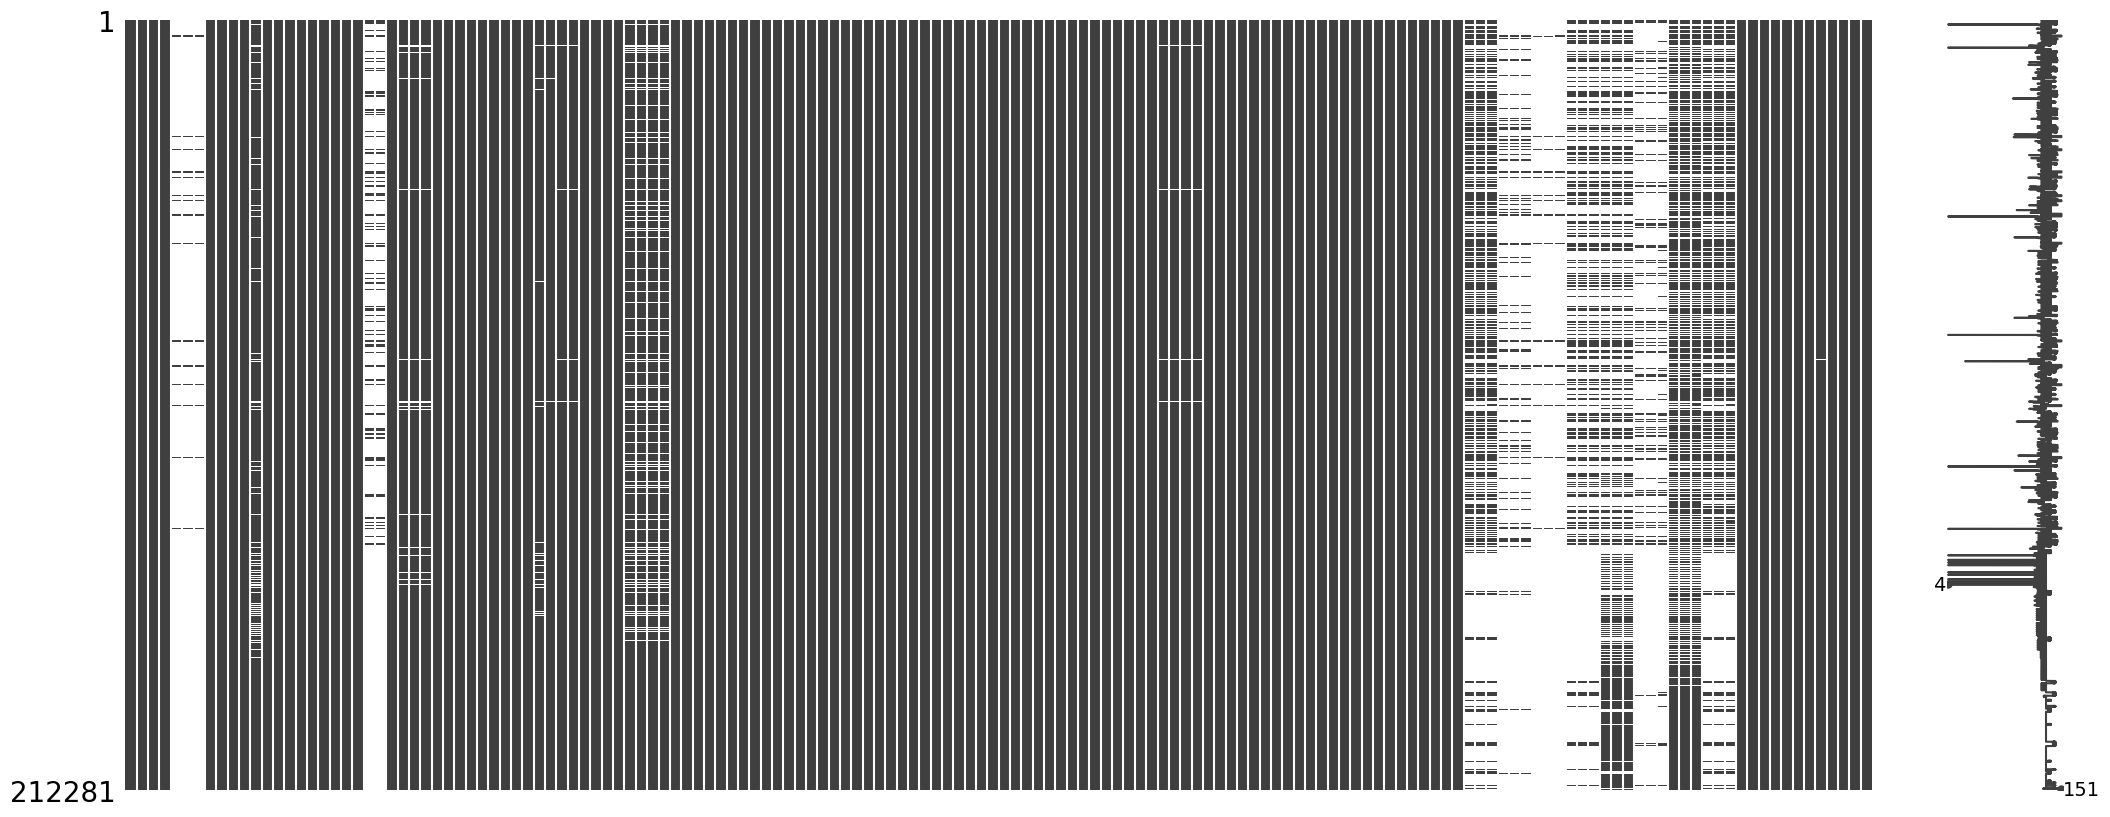

In [21]:
import missingno as msno
msno.matrix(climate_data_per_month_loc_filled)

#### Dropping columns with mastly NaN's and filling remaining missing values

In [22]:
# Filter columns that have less than 50% missing values
threshold = 0.5
columns_to_keep = climate_data_per_month_loc_filled.columns[climate_data_per_month_loc_filled.isna().mean() < threshold]
climate_data_per_month_loc_filled = climate_data_per_month_loc_filled[columns_to_keep]

# Fill missing values with the column mean (ignoring region-specific data)
for column in climate_data_per_month_loc_filled.columns:
    if climate_data_per_month_loc_filled[column].isna().any() and column not in ['region', 'Year', 'Month', 'id_loc']:
        climate_data_per_month_loc_filled[column].fillna(climate_data_per_month_loc_filled[column].mean(), inplace=True)

### Saving resulting data

In [24]:
climate_data_per_month_loc_filled.to_csv('climate_data_per_month_loc_filled_noNaN_taikai.csv', index = False)